# Aim

Just get Zernikes to fit

In [49]:
import eleanor
import numpy as np
import lightkurve as lk
from matplotlib import pyplot as plt
import tqdm
import scipy.optimize as sopt
from scipy.special import iv
from zernike import RZern, FitZern
import torch
from torch.autograd import grad as tgrad
from copy import deepcopy
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
from eleanor import models, mast

In [53]:
# first, step 1: surgically extract code from afeinstein20/eleanor/master that still operates with my new API
star = eleanor.Source(tic=120362128, sector=14, tc=True)
star.premade = False
sc = lk.search_targetpixelfile(target='tic120362128', sector=14).download()
sq = sc.quality < 5000
start = 2500
end = 3400
time = sc.time[sq][start:end].value
tpfs = sc.flux[sq][start:end].value
errs = sc.flux_err[sq][start:end].value
bkgs = sc.flux_bkg[sq,0,0][start:end].value
bkg0 = np.mean(bkgs)
data = eleanor.TargetData(
    star, 
    height=11, 
    width=11, 
    do_pca=True,
    do_psf=False,
)
sources_in_tpf = mast.gaia_sources_in_tpf(star, 10, tpfs.shape[1:])
xc = np.array(sources_in_tpf.coords_x) + tpfs.shape[2] / 2
yc = np.array(sources_in_tpf.coords_y) + tpfs.shape[1] / 2
x, y = np.meshgrid(range(-58, 59), range(-58, 59)) 

In [59]:
data.psf_lightcurve(data_arr=tpfs, err_arr=errs, bkg_arr=bkgs, model_name='Zernike', verbose=True, bkg_mag_cutoff=10, ignore_pixels=1)

100%|██████████| 900/900 [19:17<00:00,  1.29s/it]


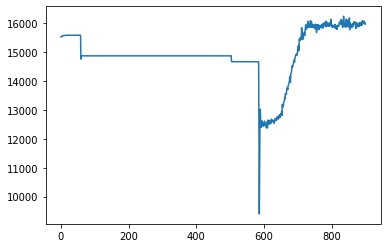

In [60]:
plt.plot(data.psf_flux[:,1])

In [62]:
data_g = deepcopy(data)

In [63]:
data_g.psf_lightcurve(data_arr=tpfs, err_arr=errs, bkg_arr=bkgs, model_name='Gaussian', verbose=True, bkg_mag_cutoff=10, ignore_pixels=1)

100%|██████████| 900/900 [02:37<00:00,  5.71it/s]


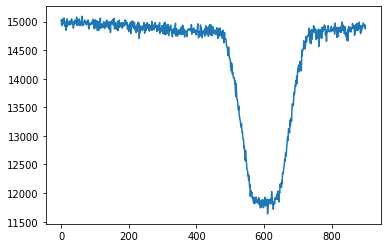

In [64]:
plt.plot(data_g.psf_flux[:,1])

Text(0.5, 1.0, 'PSF-corrected light curves for crowded field (TIC 120362128)')

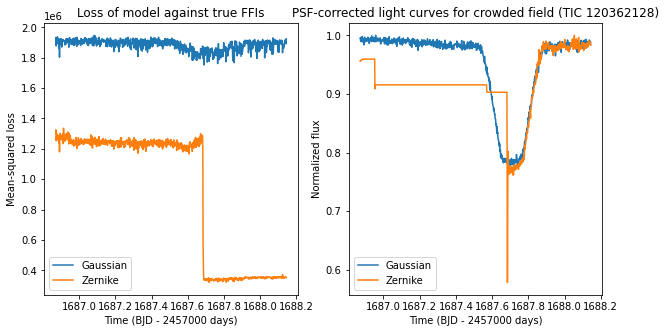

In [65]:
f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(time, data_g.psf_ll, label='Gaussian')
ax[0].plot(time, data.psf_ll, label='Zernike')
ax[0].legend()
ax[0].set_xlabel("Time (BJD - 2457000 days)")
ax[0].set_ylabel("Mean-squared loss")
ax[0].set_title("Loss of model against true FFIs")
ax[1].plot(time, data_g.psf_flux[:,1] / np.max(data_g.psf_flux[:,1]), label='Gaussian')
ax[1].plot(time, data.psf_flux[:,1] / np.max(data.psf_flux[:,1]), label='Zernike')
ax[1].legend()
ax[1].set_xlabel("Time (BJD - 2457000 days)")
ax[1].set_ylabel("Normalized flux")
ax[1].set_title("PSF-corrected light curves for crowded field (TIC 120362128)")
# plt.savefig('./compare_lc.png')

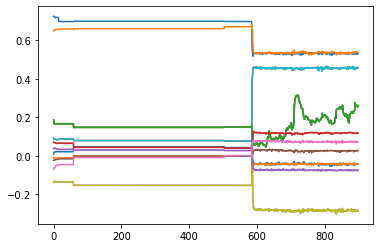

In [66]:
plt.plot(data.psf_params)

In [69]:
data.psf_params[899]

array([ 0.53327668,  0.53815343,  0.2567228 ,  0.45743718, -0.28847825,
        0.2567228 , -0.0757324 ,  0.11844995, -0.28847825,  0.45743718,
       -0.04414153, -0.04167375,  0.2567228 ,  0.11844995, -0.0757324 ,
        0.02526562,  0.07075336])

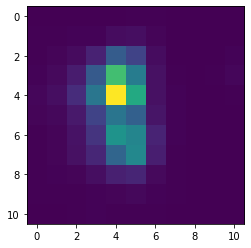

In [110]:
plt.imshow(tpfs[0])

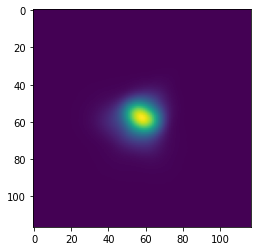

In [111]:
plt.imshow(prf)

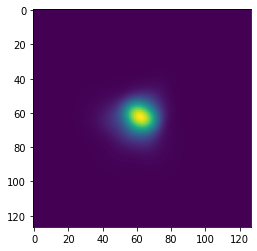

In [112]:
from scipy.signal import convolve2d
plt.imshow(convolve2d(prf, tpfs[0]))

In [129]:
1 - np.mean(data.psf_ll) / np.mean(data_g.psf_ll)

AttributeError: 'TargetData' object has no attribute 'psf_ll'

In [38]:
lk.estimate_cdpp(data_g.psf_flux[:,1]).value

2137.33842023823

In [37]:
lk.estimate_cdpp(data.psf_flux[:,1]).value

2406.1056212082067

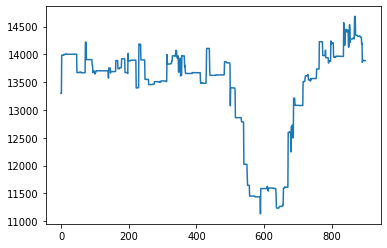

In [28]:
plt.plot(data.psf_flux[:,1])

In [169]:
data.psf_params[0]

array([ 1.00000000e+00,  6.32472869e-01, -1.44048192e-03, -2.82599191e-03,
       -6.08317986e-01,  4.20081374e-03, -2.84860087e-03, -9.19980142e-04,
        2.24813244e-03,  1.55329483e-04,  1.08086588e-03,  1.27810881e-02,
        2.64896892e-03, -4.85427269e-03, -1.30814597e-04, -9.55529364e-04])

In [38]:
zernmodel = eleanor.models.Zernike(
    shape=(11,11),
    col_ref=0,
    row_ref=0,
    xc=xc,
    yc=yc,
    bkg0=bkg0,
    loss=None,
    source=star
)

AttributeError: module 'eleanor' has no attribute 'models'

In [58]:
zernmodel.zpars

array([ 1.09184332e-01, -1.45205934e-03, -2.84481957e-03, -5.27177534e-02,
        4.16214831e-03, -2.87880837e-03, -9.43701418e-04,  2.23552375e-03,
        1.50715429e-04,  1.06101866e-03,  1.28122959e-02,  2.62769921e-03,
       -4.90537634e-03, -1.90283084e-04, -9.72907680e-04, -3.86303301e-04,
        2.75168351e-04, -2.05992081e-04,  1.12589931e-03, -2.36696560e-04,
        1.48563323e-04, -2.05164856e-03,  1.87304886e-03, -1.04975452e-03,
        5.19002101e-04,  2.40511476e-04,  1.51873374e-05, -1.13042640e-04])

In [45]:
prf = eleanor.make_prf_from_source(star)

In [57]:
zern = RZern(6)

In [89]:
xtest, ytest = np.meshgrid(np.arange(-5, 6), np.arange(-5, 6))
rhotest, thetatest = np.sqrt(xtest ** 2 + ytest ** 2), np.arctan2(ytest, xtest)